In [5]:
# ==========================================================
# WHO Air Quality Analysis
# PCA + Regression + Classification Pipeline
# ==========================================================

import os
import warnings
warnings.filterwarnings("ignore")

# Data & Math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML Tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    classification_report, confusion_matrix, roc_curve, auc
)

# ----------------------------------------------------------
# Config
# ----------------------------------------------------------
DATA_PATH   = "air_quality.xlsx"       # dataset path
TARGET      = "pm25_concentration"     # target column
OUT_DIR     = "outputs"
RANDOM_STATE = 42
TEST_SIZE    = 0.2

os.makedirs(OUT_DIR, exist_ok=True)
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})


In [6]:

# ----------------------------------------------------------
# 1. Load Data
# ----------------------------------------------------------
print("🔹 Loading dataset...")
if DATA_PATH.lower().endswith((".xls", ".xlsx")):
    xls = pd.ExcelFile(DATA_PATH)
    sheet = max(xls.sheet_names, key=lambda s: pd.read_excel(xls, s).shape[0])
    df = pd.read_excel(xls, sheet_name=sheet)
else:
    df = pd.read_csv(DATA_PATH)

print("✅ Dataset loaded. Shape:", df.shape)
print(df.head(), "\n")


🔹 Loading dataset...
✅ Dataset loaded. Shape: (40098, 20)
  who_region iso3 country_name          city    year  \
0      4_Eur  ESP        Spain  A Coruna/ESP  2013.0   
1      4_Eur  ESP        Spain  A Coruna/ESP  2014.0   
2      4_Eur  ESP        Spain  A Coruna/ESP  2015.0   
3      4_Eur  ESP        Spain  A Coruna/ESP  2016.0   
4      4_Eur  ESP        Spain  A Coruna/ESP  2017.0   

                                             version  pm10_concentration  \
0  V4.0 (2018), V4.0 (2018), V4.0 (2018), V4.0 (2...              23.238   
1           V6.0  (2023), V6.0  (2023), V6.0  (2023)              27.476   
2  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              25.515   
3  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              23.057   
4  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              26.849   

   pm25_concentration  no2_concentration  pm10_tempcov  pm25_tempcov  \
0              11.491             28.841          87.0          46.0   
1   

In [7]:

# ----------------------------------------------------------
# 2. Feature Selection & Cleaning
# ----------------------------------------------------------
candidate_numeric = [
    "pm25_concentration", "pm10_concentration", "no2_concentration",
    "o3_concentration", "pm25_coverage", "pm10_coverage",
    "no2_coverage", "o3_coverage"
]
meta_cols = [c for c in ["who_region", "country", "city", "year"] if c in df.columns]
num_cols  = [c for c in candidate_numeric if c in df.columns]

data = df[meta_cols + num_cols].copy()

# Drop missing targets
data = data.dropna(subset=[TARGET])
print("✅ After dropping NaNs in target:", data.shape)

# Fill numeric NaNs with median
for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")
    data[c] = data[c].fillna(data[c].median())






✅ After dropping NaNs in target: (21730, 6)


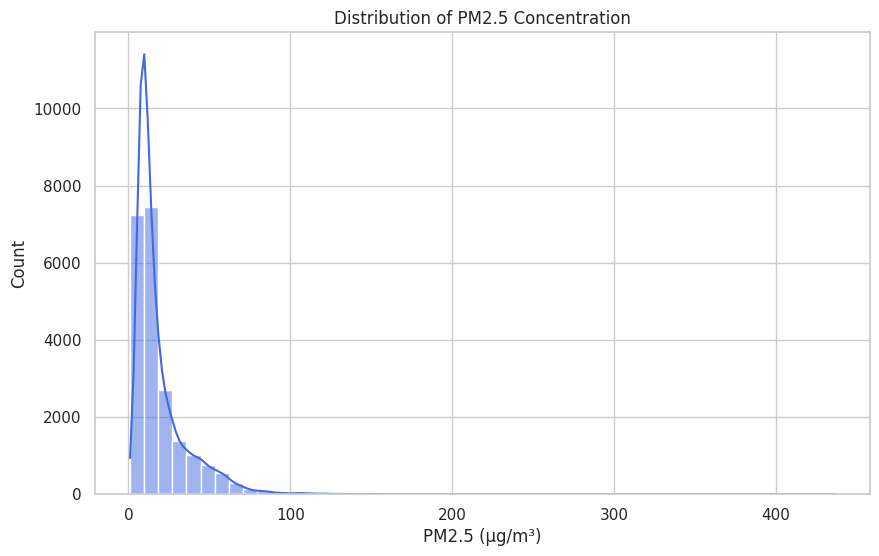

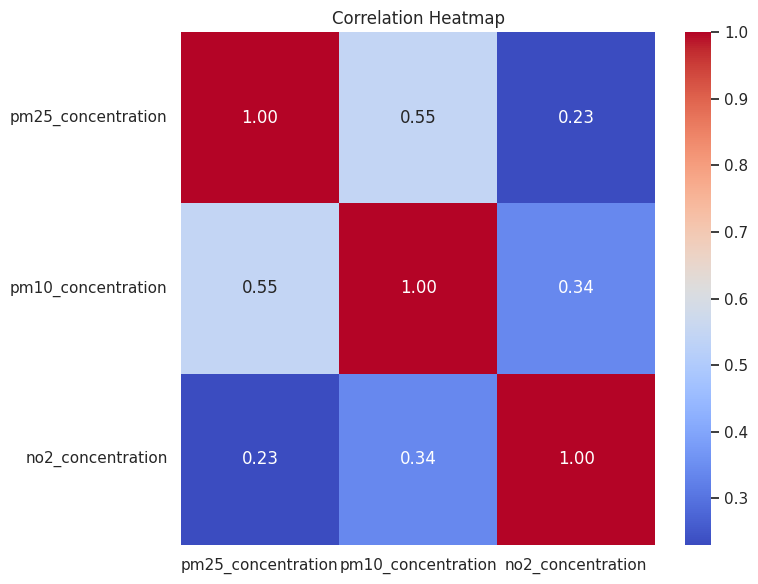

In [8]:
# ----------------------------------------------------------
# 3. Exploratory Data Analysis (EDA)
# ----------------------------------------------------------
plt.figure()
sns.histplot(data[TARGET], bins=50, kde=True, color="royalblue")
plt.title("Distribution of PM2.5 Concentration")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Count")
plt.savefig(os.path.join(OUT_DIR, "eda_distribution_pm25.png"))
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(data[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_correlation.png"))
plt.show()


🔹 PCA Explained Variance Ratios: [0.6697113 0.3302887] 



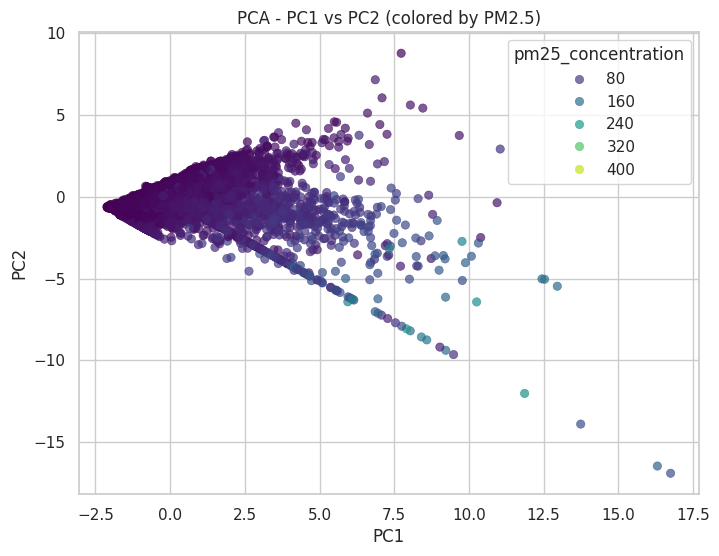

In [14]:
# ----------------------------------------------------------
# 4. PCA
# ----------------------------------------------------------
features = [c for c in num_cols if c != TARGET]
X_pca = data[features].values
X_scaled = StandardScaler().fit_transform(X_pca)

n_features = X_scaled.shape[1]
pca = PCA(n_components=min(3, n_features), random_state=RANDOM_STATE)
X_pca_res = pca.fit_transform(X_scaled)

print("🔹 PCA Explained Variance Ratios:", pca.explained_variance_ratio_, "\n")

pca_df = pd.DataFrame(X_pca_res, columns=[f"PC{i+1}" for i in range(X_pca_res.shape[1])])
pca_df[TARGET] = data[TARGET].values

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue=TARGET, data=pca_df,
                palette="viridis", alpha=0.7, edgecolor=None)
plt.title("PCA - PC1 vs PC2 (colored by PM2.5)")
plt.savefig(os.path.join(OUT_DIR, "pca_scatter.png"))
plt.show()


📊 Linear Regression Performance:
  R²   = 0.303
  RMSE = 15.544
  MAE  = 9.786



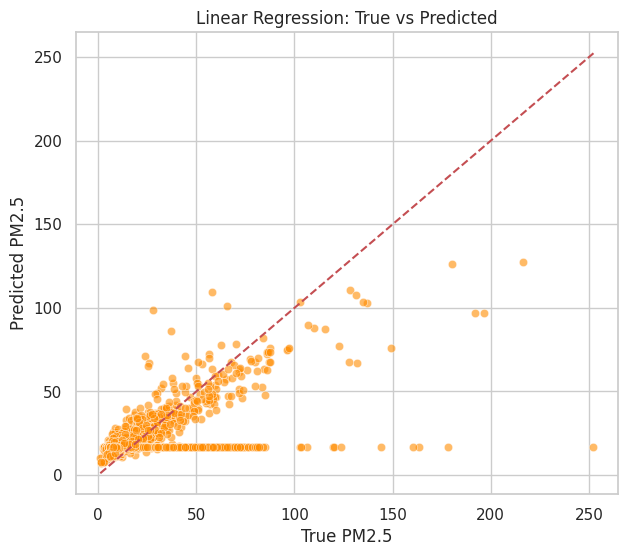

In [10]:

# ----------------------------------------------------------
# 5. Regression (Linear Regression)
# ----------------------------------------------------------
X = data[features].values
y = data[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Metrics
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("📊 Linear Regression Performance:")
print(f"  R²   = {r2:.3f}")
print(f"  RMSE = {rmse:.3f}")
print(f"  MAE  = {mae:.3f}\n")

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="darkorange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Linear Regression: True vs Predicted")
plt.savefig(os.path.join(OUT_DIR, "regression_true_vs_pred.png"))
plt.show()


📊 Classification Report (High vs Low PM2.5):
              precision    recall  f1-score   support

           0       0.65      0.86      0.74      2173
           1       0.79      0.54      0.64      2173

    accuracy                           0.70      4346
   macro avg       0.72      0.70      0.69      4346
weighted avg       0.72      0.70      0.69      4346
 



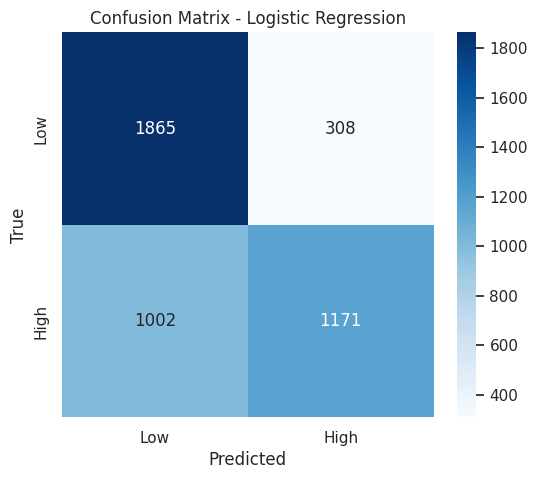

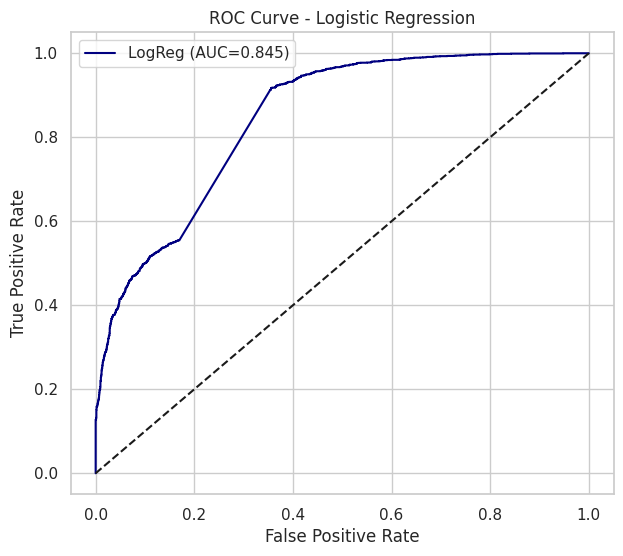

In [11]:
# ----------------------------------------------------------
# 6. Classification (Logistic Regression)
# ----------------------------------------------------------
median_pm25 = np.median(y)
data["pm25_high"] = (data[TARGET] > median_pm25).astype(int)

Xc = data[features].values
yc = data["pm25_high"].values

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=yc
)

scaler_c = StandardScaler()
Xc_train_scaled = scaler_c.fit_transform(Xc_train)
Xc_test_scaled  = scaler_c.transform(Xc_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xc_train_scaled, yc_train)
yc_pred = logreg.predict(Xc_test_scaled)
yc_prob = logreg.predict_proba(Xc_test_scaled)[:, 1]

print("📊 Classification Report (High vs Low PM2.5):")
print(classification_report(yc_test, yc_pred), "\n")

cm = confusion_matrix(yc_test, yc_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(OUT_DIR, "classification_confusion_matrix.png"))
plt.show()

fpr, tpr, _ = roc_curve(yc_test, yc_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"LogReg (AUC={roc_auc:.3f})", color="navy")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "classification_roc_curve.png"))
plt.show()

In [12]:
# ----------------------------------------------------------
# 7. Sample Predictions
# ----------------------------------------------------------
sample_idx = np.random.choice(len(X_test_scaled), 10, replace=False)
sample_reg = pd.DataFrame({
    "True_PM25": y_test[sample_idx],
    "Pred_PM25": y_pred[sample_idx]
})
print("🔹 Sample Regression Predictions (10 rows):")
print(sample_reg.to_string(index=False), "\n")

sample_idx_c = np.random.choice(len(Xc_test_scaled), 10, replace=False)
sample_clf = pd.DataFrame({
    "True_Class": yc_test[sample_idx_c],
    "Pred_Class": yc_pred[sample_idx_c],
    "Prob_High": yc_prob[sample_idx_c]
})
sample_clf["True_Class"] = sample_clf["True_Class"].map({0: "Low", 1: "High"})
sample_clf["Pred_Class"] = sample_clf["Pred_Class"].map({0: "Low", 1: "High"})
print("🔹 Sample Classification Predictions (10 rows):")
print(sample_clf.to_string(index=False), "\n")



🔹 Sample Regression Predictions (10 rows):
 True_PM25  Pred_PM25
    18.396  20.855949
    10.354  19.553110
     8.100  17.042145
     9.659  16.041078
    35.670  17.042145
    25.400  19.060408
     8.800  15.900424
    11.156  17.217567
    13.536  19.114051
    12.530  14.902546 

🔹 Sample Classification Predictions (10 rows):
True_Class Pred_Class  Prob_High
      High       High   1.000000
      High       High   0.884978
       Low        Low   0.454280
       Low        Low   0.131410
      High        Low   0.171585
      High       High   0.999999
      High        Low   0.458163
      High       High   0.885994
      High       High   0.817845
      High       High   1.000000 



In [13]:
# ----------------------------------------------------------
# 8. Metrics Summary Table
# ----------------------------------------------------------
summary_df = pd.DataFrame({
    "Model": ["Linear Regression", "Logistic Regression"],
    "R²":    [r2, None],
    "RMSE":  [rmse, None],
    "MAE":   [mae, None],
    "ROC AUC": [None, roc_auc]
})

print("📊 Final Metrics Summary:\n")
print(summary_df.to_string(index=False), "\n")

# ----------------------------------------------------------
# 9. Conclusion
# ----------------------------------------------------------
print("===================================================")
print("✅ Analysis Complete")
print("All plots displayed & saved in:", OUT_DIR)
print("===================================================")


📊 Final Metrics Summary:

              Model       R²      RMSE      MAE  ROC AUC
  Linear Regression 0.303357 15.544146 9.785879      NaN
Logistic Regression      NaN       NaN      NaN 0.844786 

✅ Analysis Complete
All plots displayed & saved in: outputs
